# Preprocessing

In [4]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#input data excel
data_kerja = '/data/angket_industri.xlsx' #data siswa diterima DU/DI

#data nilai siswa semua jurusan
data_tkj = '/data/Data TKJ.xlsx'
data_tp = '/data/Data TP .xlsx'
data_tbsm = '/data/NILAI TRANSKRIP TBSM.xlsx'
data_tei = '/data/NILAI TRANSKRIP TEI.xlsx'
data_tpm = '/data/Nil TPm_Transkrip.xlsx'
data_tkro = '/data/Nilai  TKRO.xlsx'
data_dpib = '/data/Transkip - DPIB.xlsx'
data_titl = '/data/Transkip - TITL.xlsx'

#membaca data excel dalam dataframe
df_kerja = pd.read_excel(data_kerja)
df_tkj = pd.read_excel(data_tkj)
df_tp = pd.read_excel(data_tp)
df_tbsm = pd.read_excel(data_tbsm)
df_tei = pd.read_excel(data_tei)
df_tpm = pd.read_excel(data_tpm)
df_tkro = pd.read_excel(data_tkro)
df_dpib = pd.read_excel(data_dpib)
df_titl = pd.read_excel(data_titl)

In [7]:
import numpy as np
import pandas as pd
!pip install fuzzywuzzy
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Data Integration and Cleaning
df_nilai = pd.concat([df_tkj, df_tp, df_tbsm, df_tei, df_tpm, df_tkro, df_dpib, df_titl], axis=0)
df_nilai = df_nilai.drop(columns=['KELAS', 'NIS'], axis=1)
df_kerja = df_kerja.drop(columns=['Timestamp', 'NAMA SISWA', 'Email Address', 'TEMPAT LAHIR', 'TANGGAL LAHIR', 'KELAS', 'ASAL MTs/SMP', 'ALAMAT RUMAH', 'NO WA '], axis=1)
df_kerja.rename(columns = {'NAMA':'NAMA SISWA'}, inplace = True)

from fuzzywuzzy import process
def match_names(name, name_list, threshold=80):
    match, score = process.extractOne(name, name_list)
    if score >= threshold:
        return match
    else:
        return None

df_kerja['Matched_NAME'] = df_kerja['NAMA SISWA'].apply(lambda x: match_names(x, df_nilai['NAMA SISWA'].tolist()))
df_gabung = pd.merge(df_nilai, df_kerja, left_on='NAMA SISWA', right_on='Matched_NAME', how='outer')
df_gabung[df_gabung[['NAMA SISWA_x']].isnull().all(1)]
df_gabung = df_gabung.dropna(subset=['NAMA SISWA_x'])
df_gabung['NAMA SISWA_y']=df_gabung['Matched_NAME']
df_gabung=df_gabung.drop(columns=['Matched_NAME', 'NAMA SISWA_y', 'NO'])

df_gabung.rename(columns = {'DITERIMA INDUSTRI/MAGANG JEPANG':'BERSAING DI DUNIA KERJA', 'NAMA SISWA_x':'NAMA SISWA'}, inplace = True)
df_gabung['BERSAING DI DUNIA KERJA'] = df_gabung['BERSAING DI DUNIA KERJA'].apply(lambda x: "MAMPU" if pd.notna(x) and x != '' else "BELUM MAMPU")
df_gabung = df_gabung.drop_duplicates(subset='NAMA SISWA', keep='first')
#Membuat fungsi inisial nama
def get_initials(name):
    parts = name.split()
    initials = ''.join([part[0].upper() for part in parts])
    return initials

df_gabung['NAMA SISWA'] = df_gabung['NAMA SISWA'].apply(get_initials)

# Menghapus sebagian data yang berlabel belum mammpu sehingga data menjadi seimbang
data_bmampu = df_gabung[df_gabung['BERSAING DI DUNIA KERJA'] == 'BELUM MAMPU']
selisih = (df_gabung[df_gabung['BERSAING DI DUNIA KERJA'] == 'BELUM MAMPU'].shape[0])-(df_gabung[df_gabung['BERSAING DI DUNIA KERJA'] == 'MAMPU'].shape[0])
rows_to_delete = data_bmampu.sample(n=selisih, random_state=42)
df_sama = df_gabung.drop(rows_to_delete.index)



/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
# Menentukan fitur (X) dan label (Y)
X = df_sama.drop(['BERSAING DI DUNIA KERJA', 'NAMA SISWA'], axis=1)
Y = df_sama['BERSAING DI DUNIA KERJA']
results = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1_score': {}}

# Menentukan fitur (X) dan label (Y)
X = df_sama.drop(['BERSAING DI DUNIA KERJA', 'NAMA SISWA'], axis=1)
Y = df_sama['BERSAING DI DUNIA KERJA']
results = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1_score': {}}

# Menentukan ukuran tes dan membuat pembagian data latih dan uji coba
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
train_test_sets = [train_test_split(X, Y, test_size=size, random_state=0) for size in test_sizes]

# Data transformation (Scaling)
scaler = StandardScaler()
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for X_train, X_test, y_train, y_test in train_test_sets:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_list.append(X_train_scaled)
    X_test_list.append(X_test_scaled)
    y_train_list.append(y_train)
    y_test_list.append(y_test)


## Data Mining

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Melakukan perulangan pada dataset yang sudah dibagi
for idx, test_size in enumerate(test_sizes):
    accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    X_train = X_train_list[idx]
    X_test = X_test_list[idx]
    y_train = y_train_list[idx]
    y_test = y_test_list[idx]

    # Melakukan perulangan pada nilai k (1 sampai 10)
    for k in range(1, 11):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Pengukuran akurasi, presisi, recall, dan f1-score
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, pos_label='MAMPU'))
        recall_scores.append(recall_score(y_test, y_pred, pos_label='MAMPU'))
        f1_scores.append(f1_score(y_test, y_pred, pos_label='MAMPU'))

    results['accuracy'][test_size] = accuracy_scores
    results['precision'][test_size] = precision_scores
    results['recall'][test_size] = recall_scores
    results['f1_score'][test_size] = f1_scores

# Membuat dataframe pada tiap pengukuran
df_accuracy_results = pd.DataFrame(results['accuracy']).T
df_precision_results = pd.DataFrame(results['precision']).T
df_recall_results = pd.DataFrame(results['recall']).T
df_f1_score_results = pd.DataFrame(results['f1_score']).T

for df in [df_accuracy_results, df_precision_results, df_recall_results, df_f1_score_results]:
    df.columns = [f'k={k}' for k in range(1, 11)]
    df.index = [f'Data Uji {int(test_size * 100)}%' for test_size in test_sizes]

df_accuracy_results = (df_accuracy_results * 100).round(2).T
df_precision_results = (df_precision_results * 100).round(2).T
df_recall_results = (df_recall_results * 100).round(2).T
df_f1_score_results = (df_f1_score_results * 100).round(2).T




---



In [17]:
df_accuracy_results

,Data Uji 10%,Data Uji 20%,Data Uji 30%,Data Uji 40%,Data Uji 50%
k=1,53.33,57.63,53.93,46.61,52.38
k=2,33.33,47.46,44.94,42.37,48.30
k=3,50.00,57.63,58.43,55.08,57.82
k=4,43.33,52.54,50.56,53.39,50.34
k=5,66.67,66.10,62.92,55.08,58.50
k=6,56.67,57.63,53.93,52.54,55.78
k=7,56.67,57.63,55.06,55.08,59.18
k=8,53.33,52.54,53.93,51.69,57.14
k=9,53.33,54.24,57.30,55.93,57.82
k=10,53.33,55.93,52.81,52.54,50.34


In [18]:
df_precision_results

,Data Uji 10%,Data Uji 20%,Data Uji 30%,Data Uji 40%,Data Uji 50%
k=1,80.00,76.19,67.65,55.56,57.97
k=2,50.00,72.73,64.29,50.00,56.10
k=3,72.73,73.91,72.22,65.96,63.01
k=4,71.43,75.00,66.67,69.70,57.69
k=5,81.25,78.57,75.00,64.71,63.16
k=6,81.82,78.95,71.43,65.00,63.79
k=7,70.59,70.37,67.57,63.64,63.64
k=8,75.00,70.00,68.75,64.10,66.07
k=9,66.67,65.52,68.29,66.67,63.38
k=10,71.43,70.83,67.74,65.79,57.14


In [19]:
df_recall_results

,Data Uji 10%,Data Uji 20%,Data Uji 30%,Data Uji 40%,Data Uji 50%
k=1,40.0,44.44,43.40,36.76,49.38
k=2,10.0,22.22,16.98,16.18,28.40
k=3,40.0,47.22,49.06,45.59,56.79
k=4,25.0,33.33,33.96,33.82,37.04
k=5,65.0,61.11,56.60,48.53,59.26
k=6,45.0,41.67,37.74,38.24,45.68
k=7,60.0,52.78,47.17,51.47,60.49
k=8,45.0,38.89,41.51,36.76,45.68
k=9,60.0,52.78,52.83,47.06,55.56
k=10,50.0,47.22,39.62,36.76,39.51


In [20]:
df_f1_score_results

,Data Uji 10%,Data Uji 20%,Data Uji 30%,Data Uji 40%,Data Uji 50%
k=1,53.33,56.14,52.87,44.25,53.33
k=2,16.67,34.04,26.87,24.44,37.70
k=3,51.61,57.63,58.43,53.91,59.74
k=4,37.04,46.15,45.00,45.54,45.11
k=5,72.22,68.75,64.52,55.46,61.15
k=6,58.06,54.55,49.38,48.15,53.24
k=7,64.86,60.32,55.56,56.91,62.03
k=8,56.25,50.00,51.76,46.73,54.01
k=9,63.16,58.46,59.57,55.17,59.21
k=10,58.82,56.67,50.00,47.17,46.72


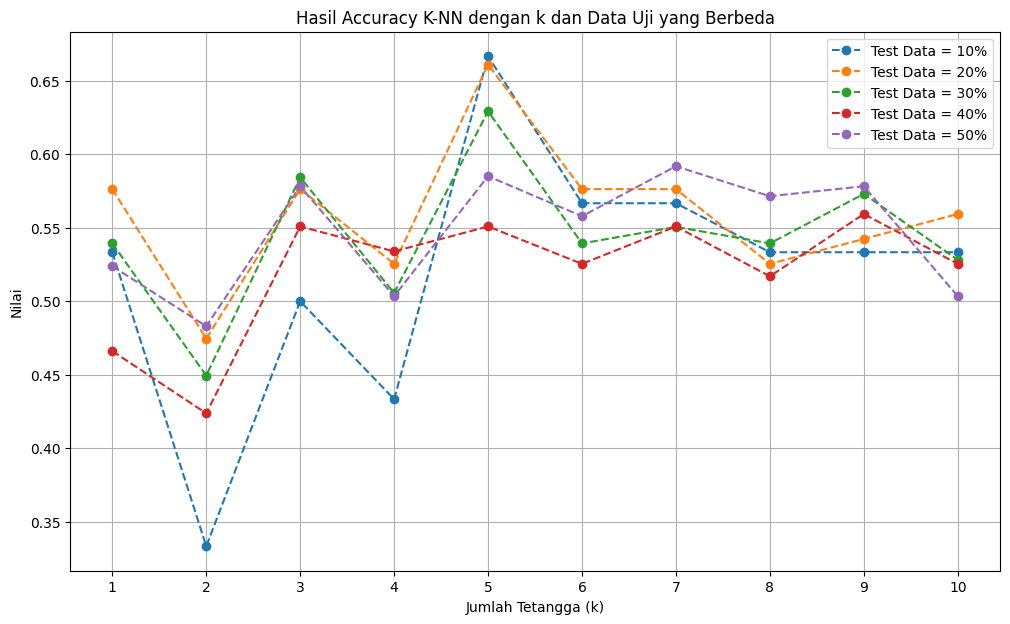

In [21]:
# Grafik hasil Accuracy
plt.figure(figsize=(12, 7))
for test_sizes, scores in results['accuracy'].items():
    # Plot untuk nilai k dari 1 hingga 10
    plt.plot(range(1, 11), scores, marker='o', label=f'Test Data = {int(test_sizes * 100)}%', linestyle='--')

plt.xlabel('Jumlah Tetangga (k)')
plt.ylabel('Nilai')
plt.title('Hasil Accuracy K-NN dengan k dan Data Uji yang Berbeda')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

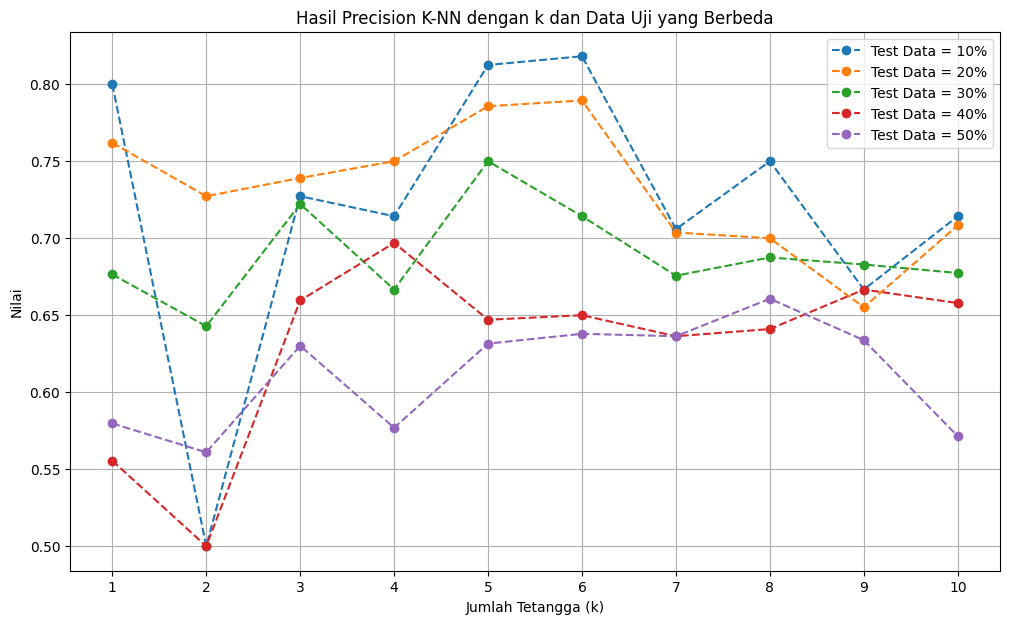

In [22]:
#Grafik hasil Precision
plt.figure(figsize=(12, 7))
for test_sizes, scores in results['precision'].items():
    # Plot for odd values of k (3, 5, 7, 9)
    plt.plot(range(1, 11), scores, marker='o', label=f'Test Data = {int(test_sizes * 100)}%', linestyle='--')

plt.xlabel('Jumlah Tetangga (k)')
plt.ylabel('Nilai')
plt.title('Hasil Precision K-NN dengan k dan Data Uji yang Berbeda')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

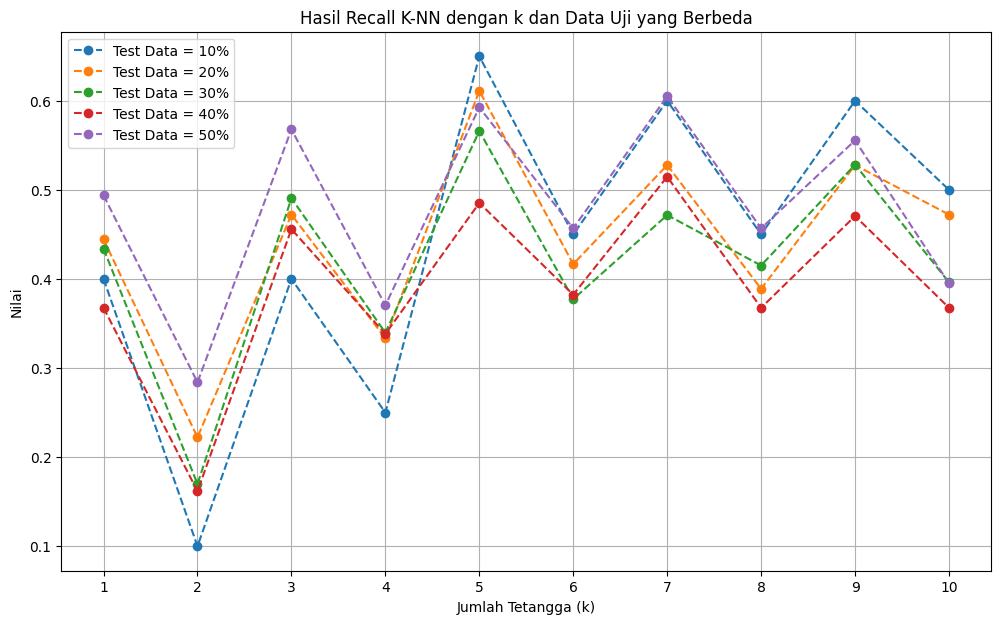

In [23]:
#Grafik hasil Recall
plt.figure(figsize=(12, 7))
for test_sizes, scores in results['recall'].items():
    # Plot for odd values of k (3, 5, 7, 9)
    plt.plot(range(1, 11), scores, marker='o', label=f'Test Data = {int(test_sizes * 100)}%', linestyle='--')

plt.xlabel('Jumlah Tetangga (k)')
plt.ylabel('Nilai')
plt.title('Hasil Recall K-NN dengan k dan Data Uji yang Berbeda')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

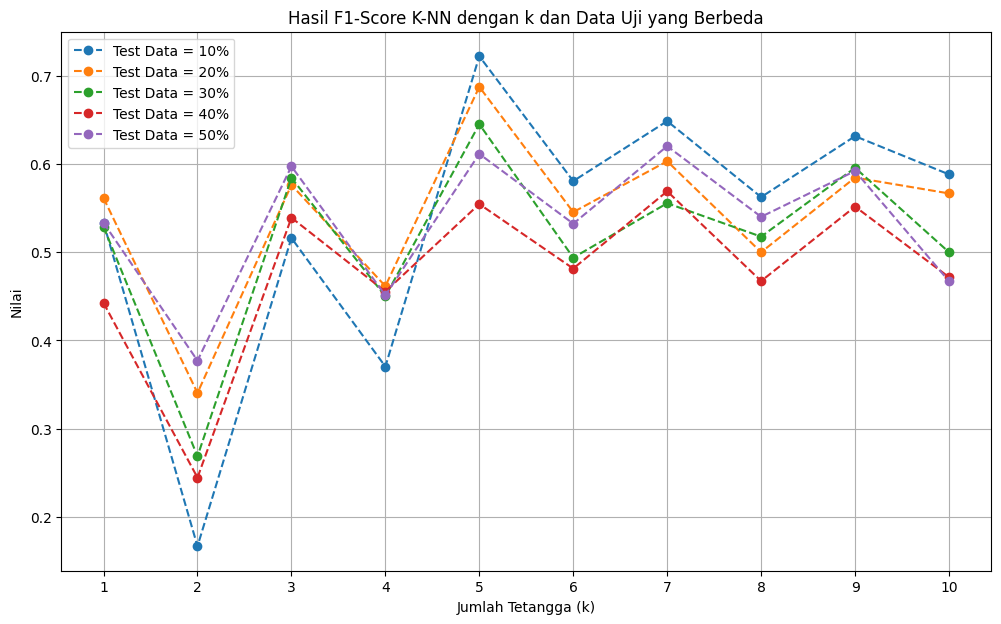

In [24]:
#Grafik hasil F1-Score
plt.figure(figsize=(12, 7))
for test_sizes, scores in results['f1_score'].items():
    # Plot for odd values of k (3, 5, 7, 9)
    plt.plot(range(1, 11), scores, marker='o', label=f'Test Data = {int(test_sizes * 100)}%', linestyle='--')

plt.xlabel('Jumlah Tetangga (k)')
plt.ylabel('Nilai')
plt.title('Hasil F1-Score K-NN dengan k dan Data Uji yang Berbeda')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

 BELUM MAMPU       0.50      0.70      0.58        10
       MAMPU       0.81      0.65      0.72        20

    accuracy                           0.67        30
   macro avg       0.66      0.68      0.65        30
weighted avg       0.71      0.67      0.68        30



Text(0.5, 23.52222222222222, 'Predicted label')

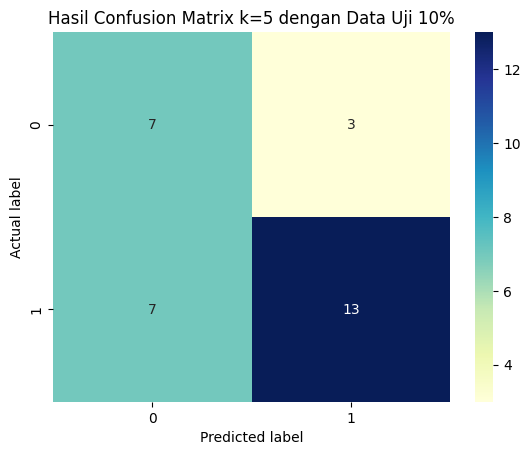

In [25]:
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
print(classification_report(y_test,y_pred))
plt.title('Hasil Confusion Matrix k=5 dengan Data Uji 10%')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Proses klasifikasi berdasarkan akurasi tertinggi

In [26]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_5.fit(X_train_scaled, y_train)
y_pred = knn_5.predict(X_test_scaled)
y_pred

array(['BELUM MAMPU', 'MAMPU', 'BELUM MAMPU', 'MAMPU', 'BELUM MAMPU',
       'MAMPU', 'BELUM MAMPU', 'BELUM MAMPU', 'BELUM MAMPU', 'MAMPU',
       'BELUM MAMPU', 'MAMPU', 'MAMPU', 'BELUM MAMPU', 'MAMPU',
       'BELUM MAMPU', 'MAMPU', 'MAMPU', 'MAMPU', 'BELUM MAMPU', 'MAMPU',
       'MAMPU', 'MAMPU', 'BELUM MAMPU', 'MAMPU', 'MAMPU', 'BELUM MAMPU',
       'BELUM MAMPU', 'MAMPU', 'BELUM MAMPU'], dtype=object)

In [27]:
y_test

,BERSAING DI DUNIA KERJA
486,BELUM MAMPU
472,MAMPU
106,MAMPU
516,MAMPU
50,MAMPU
534,MAMPU
406,BELUM MAMPU
439,MAMPU
134,BELUM MAMPU
173,MAMPU


In [28]:
import pandas as pd

# Assuming X_test is a DataFrame or numpy array, y_test and y_pred are numpy arrays or similar
# Convert X_test to DataFrame if it is not already
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=[f'Feature {i}' for i in range(X_test.shape[1])])
else:
    X_test_df = X_test.copy()

# Convert y_test and y_pred to DataFrame
y_test_df = pd.DataFrame(y_test)
y_pred_df = pd.DataFrame(y_pred)

# Combine X_test, y_test, and y_pred into one DataFrame
combined_df = pd.concat([ X_test_df, df_gabung['NAMA SISWA'], y_test_df], axis=1).reset_index(drop=True)
combined_df = combined_df.dropna(subset=['NSP PAI'])
# Append y_pred_df
comparison_df = pd.concat([combined_df, y_pred_df], axis=1)
comparison_df.rename(columns = {'BERSAING DI DUNIA KERJA':'Label Aktual', 0:'Label Prediksi'}, inplace = True)

# Display the comparison DataFrame
comparison_df

,NSP PAI,NSP PKn,NSP Bind,NSP MTK,NSP Sej,NSP Bing,NSP S.Bud,NSP PJOK,NSP Bjawa,NSP Simdig,NSP Fis,NSP Kim,NSP C2,NSP C3,PKL,NAMA SISWA,Label Aktual,Label Prediksi
0,83.42,81.92,75.81,77.48,77.93,77.94,82.43,84.35,77.38,79.46,76.64,77.01,79.79,81.62,76.0,PEE,BELUM MAMPU,BELUM MAMPU
1,81.42,82.71,77.92,78.52,79.75,80.57,80.88,79.23,78.13,77.97,80.63,77.54,79.92,83.17,80.0,NA,MAMPU,MAMPU
2,79.93,82.62,77.98,78.99,80.04,80.34,80.47,81.50,80.09,78.81,77.31,75.88,78.46,80.69,83.0,AARS,MAMPU,BELUM MAMPU
3,78.36,83.98,75.51,78.58,79.57,77.39,80.70,84.97,76.53,80.84,81.35,75.61,77.57,82.24,85.0,RSB,MAMPU,MAMPU
4,83.02,82.57,76.88,76.57,87.05,79.30,82.61,80.69,78.76,82.85,77.16,81.07,80.45,84.36,93.0,ARY,MAMPU,BELUM MAMPU
5,81.68,81.99,77.90,77.42,84.20,77.96,79.25,82.18,83.09,81.90,79.05,76.98,80.72,82.94,91.0,RS,MAMPU,MAMPU
6,81.45,77.78,75.00,74.75,74.08,75.07,77.06,82.07,77.38,78.89,73.84,73.96,77.86,80.78,75.0,MAWA,BELUM MAMPU,BELUM MAMPU
7,83.29,80.20,81.06,77.96,80.86,78.04,80.34,81.79,80.61,79.66,81.74,79.02,79.19,81.06,80.0,MSMA,MAMPU,BELUM MAMPU
8,83.86,82.43,78.23,82.69,82.56,82.67,88.05,85.21,79.57,81.56,86.49,76.19,82.05,89.49,84.0,BAS,BELUM MAMPU,BELUM MAMPU
9,82.47,83.59,81.92,78.86,88.32,84.66,84.89,85.83,80.17,81.51,86.46,75.86,76.05,79.66,81.0,DAS,MAMPU,MAMPU


## Evaluation

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Membagi dataset berdasarkan hasil accuracy tertinggi
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, test_size = 0.1, random_state = 0)

# Data Normalization (Scaling)
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

# Menginisialisasi model KNN berdasarkan nilai tetangga (k) tertinggi
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_1, y_train_1)

precision_scorer = make_scorer(precision_score, pos_label='MAMPU', zero_division=1)
recall_scorer = make_scorer(recall_score, pos_label='MAMPU', zero_division=1)
f1_scorer = make_scorer(f1_score, pos_label='MAMPU', zero_division=1)

In [30]:
# Accuracy
# Proses k-fold cross validation
acc_scores_cv5 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 5, scoring='accuracy')
acc_scores_cv10 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 10, scoring='accuracy')

# Hasil tiap fold
print('\nHasil accuracy 5-fold Cross-validation: {}'.format(acc_scores_cv5))
print('Hasil accuracy 10-fold Cross-validation: {}'.format(acc_scores_cv10))

# Rata-rata hasil k-fold
print('\nRata-rata accuracy 5-fold Cross-validation mean scores: {:.4f}'.format(np.mean(acc_scores_cv5)))
print('Rata-rata accuracy 10-fold Cross-validation mean scores: {:.4f}'.format(np.mean(acc_scores_cv10)))
y_pred_1 = knn_5.predict(X_test_1)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_1, y_pred_1)))


Hasil accuracy 5-fold Cross-validation: [0.60377358 0.56603774 0.60377358 0.56603774 0.57692308]
Hasil accuracy 10-fold Cross-validation: [0.66666667 0.51851852 0.7037037  0.55555556 0.69230769 0.5
 0.61538462 0.5        0.57692308 0.65384615]

Rata-rata accuracy 5-fold Cross-validation mean scores: 0.5833
Rata-rata accuracy 10-fold Cross-validation mean scores: 0.5983
Model accuracy score: 0.6667


In [31]:
# Precision
# Proses k-fold cross validation
pre_scores_cv5 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 5, scoring=precision_scorer)
pre_scores_cv10 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 10, scoring=precision_scorer)

# Hasil tiap fold
print('\nHasil precision 5-fold Cross-validation: {}'.format(pre_scores_cv5))
print('Hasil precision 10-fold Cross-validation: {}'.format(pre_scores_cv10))

# Rata-rata hasil k-fold
print('\nRata-rata precision 5-fold Cross-validation mean scores: {:.4f}'.format(np.mean(pre_scores_cv5)))
print('Rata-rata precision 10-fold Cross-validation mean scores: {:.4f}'.format(np.mean(pre_scores_cv10)))
print('Model precision score: {0:0.4f}'. format(precision_score(y_test_1, y_pred_1, pos_label='MAMPU')))


Hasil precision 5-fold Cross-validation: [0.58333333 0.53571429 0.58064516 0.55172414 0.56      ]
Hasil precision 10-fold Cross-validation: [0.66666667 0.5        0.69230769 0.53333333 0.625      0.46666667
 0.55       0.5        0.57142857 0.66666667]

Rata-rata precision 5-fold Cross-validation mean scores: 0.5623
Rata-rata precision 10-fold Cross-validation mean scores: 0.5772
Model precision score: 0.8125


In [32]:
# Recall
# Proses k-fold cross validation
rec_scores_cv5 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 5, scoring=recall_scorer)
rec_scores_cv10 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 10, scoring=recall_scorer)

# Hasil tiap fold
print('\nHasil recall 5-fold Cross-validation: {}'.format(rec_scores_cv5))
print('Hasil recall 10-fold Cross-validation: {}'.format(rec_scores_cv10))

# Rata-rata hasil k-fold
print('\nRata-rata recall 5-fold Cross-validation mean scores: {:.4f}'.format(np.mean(rec_scores_cv5)))
print('Rata-rata recall 10-fold Cross-validation mean scores: {:.4f}'.format(np.mean(rec_scores_cv10)))
print('Model recall score: {0:0.4f}'. format(recall_score(y_test_1, y_pred_1, pos_label='MAMPU')))


Hasil recall 5-fold Cross-validation: [0.56       0.6        0.69230769 0.61538462 0.56      ]
Hasil recall 10-fold Cross-validation: [0.61538462 0.38461538 0.69230769 0.61538462 0.83333333 0.58333333
 0.91666667 0.53846154 0.61538462 0.61538462]

Rata-rata recall 5-fold Cross-validation mean scores: 0.6055
Rata-rata recall 10-fold Cross-validation mean scores: 0.6410
Model recall score: 0.6500


In [33]:
# F1-Score
# Proses k-fold cross validation
f1_scores_cv5 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 5, scoring=f1_scorer)
f1_scores_cv10 = cross_val_score(knn_5, X_train_1, y_train_1, cv = 10, scoring=f1_scorer)

# Hasil tiap fold
print('\nHasil f1-score 5-fold Cross-validation: {}'.format(f1_scores_cv5))
print('Hasil f1-score 10-fold Cross-validation: {}'.format(f1_scores_cv10))

# Rata-rata hasil k-fold
print('\nRata-rata f1-score 5-fold Cross-validation mean scores: {:.4f}'.format(np.mean(f1_scores_cv5)))
print('Rata-rata f1-score 10-fold Cross-validation mean scores: {:.4f}'.format(np.mean(f1_scores_cv10)))
print('Model f1-score score: {0:0.4f}'. format(f1_score(y_test_1, y_pred_1, pos_label='MAMPU')))


Hasil f1-score 5-fold Cross-validation: [0.57142857 0.56603774 0.63157895 0.58181818 0.56      ]
Hasil f1-score 10-fold Cross-validation: [0.64       0.43478261 0.69230769 0.57142857 0.71428571 0.51851852
 0.6875     0.51851852 0.59259259 0.64      ]

Rata-rata f1-score 5-fold Cross-validation mean scores: 0.5822
Rata-rata f1-score 10-fold Cross-validation mean scores: 0.6010
Model f1-score score: 0.7222
